Fitting: LogReg (baseline)
Fitting: RandomForest (uncalibrated)
Fitting: GradientBoosting (uncalibrated)
Calibrating RandomForest (sigmoid + isotonic)
Calibrating GradientBoosting (sigmoid + isotonic)
Evaluating: LogReg (baseline)
Evaluating: RandomForest (uncalibrated)
Evaluating: GradientBoosting (uncalibrated)
Evaluating: RF (sigmoid)
Evaluating: RF (isotonic)
Evaluating: GB (sigmoid)
Evaluating: GB (isotonic)

=== Compact Summary for Report ===
                                 val_acc  test_acc   brier  roc_auc  pr_auc
LogReg (baseline)                  0.902     0.908  0.0646   0.9362  0.7881
RandomForest (uncalibrated)        0.950     0.956  0.0390   0.9716  0.9216
GradientBoosting (uncalibrated)    0.951     0.960  0.0334   0.9674  0.9248
RF (sigmoid)                       0.940     0.948  0.0392   0.9684  0.9101
RF (isotonic)                      0.941     0.949  0.0390   0.9675  0.9059
GB (sigmoid)                       0.950     0.958  0.0333   0.9671  0.9251
GB (isotonic)  

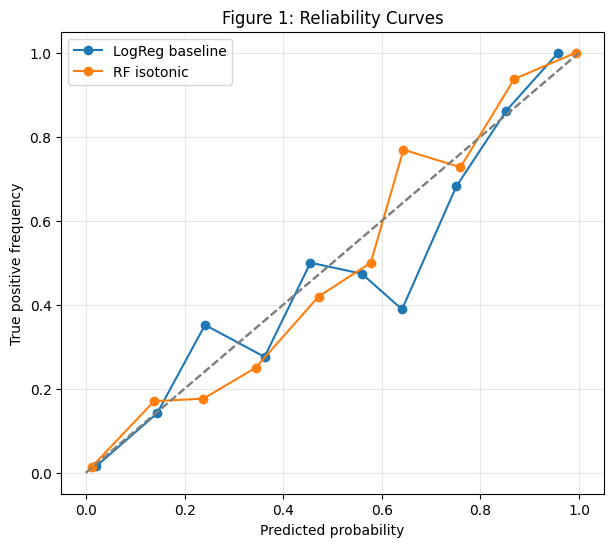

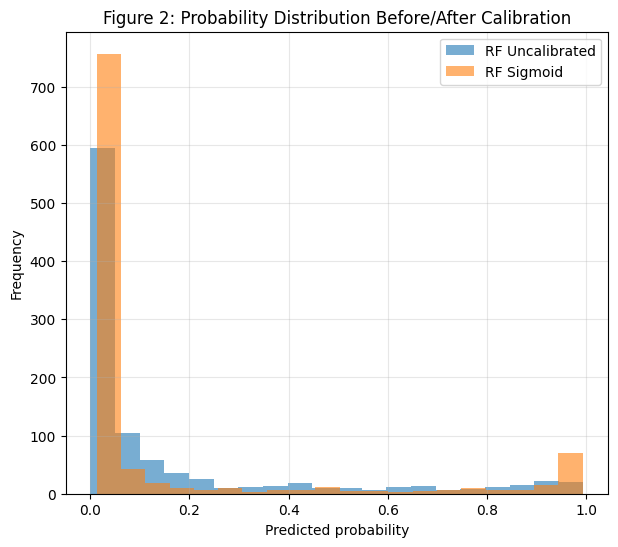

,val_acc,test_acc,brier,roc_auc,pr_auc
LogReg (baseline),0.902,0.908,0.0646,0.9362,0.7881
RandomForest (uncalibrated),0.950,0.956,0.0390,0.9716,0.9216
GradientBoosting (uncalibrated),0.951,0.960,0.0334,0.9674,0.9248
RF (sigmoid),0.940,0.948,0.0392,0.9684,0.9101
RF (isotonic),0.941,0.949,0.0390,0.9675,0.9059
GB (sigmoid),0.950,0.958,0.0333,0.9671,0.9251
GB (isotonic),0.953,0.957,0.0338,0.9653,0.9228


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, brier_score_loss, roc_auc_score, precision_recall_curve,
    average_precision_score
)
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# =============================
# 1. DATASET
# =============================
X, y = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=6,
    n_redundant=2,
    weights=[0.85, 0.15],   # Imbalanced dataset!
    class_sep=1.5,
    random_state=42
)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# =============================
# 2. DEFINE MODELS
# =============================

models = {
    "LogReg (baseline)": LogisticRegression(max_iter=300),
    "RandomForest (uncalibrated)": RandomForestClassifier(
        n_estimators=200, max_depth=None, class_weight=None, random_state=42
    ),
    "GradientBoosting (uncalibrated)": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, random_state=42
    )
}

calibrated_models = {}

# =============================
# 3. TRAIN BASE MODELS + CALIBRATED MODELS
# =============================
print("Fitting: LogReg (baseline)")
models["LogReg (baseline)"].fit(X_train_scaled, y_train)

print("Fitting: RandomForest (uncalibrated)")
models["RandomForest (uncalibrated)"].fit(X_train, y_train)

print("Fitting: GradientBoosting (uncalibrated)")
models["GradientBoosting (uncalibrated)"].fit(X_train, y_train)

# --- PROPER CALIBRATION USING estimator= ---
rf_uncal = models["RandomForest (uncalibrated)"]
gb_uncal = models["GradientBoosting (uncalibrated)"]

print("Calibrating RandomForest (sigmoid + isotonic)")
rf_sig = CalibratedClassifierCV(estimator=rf_uncal, method="sigmoid", cv=3)
rf_iso = CalibratedClassifierCV(estimator=rf_uncal, method="isotonic", cv=3)
rf_sig.fit(X_train, y_train)
rf_iso.fit(X_train, y_train)

print("Calibrating GradientBoosting (sigmoid + isotonic)")
gb_sig = CalibratedClassifierCV(estimator=gb_uncal, method="sigmoid", cv=3)
gb_iso = CalibratedClassifierCV(estimator=gb_uncal, method="isotonic", cv=3)
gb_sig.fit(X_train, y_train)
gb_iso.fit(X_train, y_train)

calibrated_models.update({
    "RF (sigmoid)": rf_sig,
    "RF (isotonic)": rf_iso,
    "GB (sigmoid)": gb_sig,
    "GB (isotonic)": gb_iso
})

# =============================
# 4. EVALUATION FUNCTION
# =============================

def evaluate(model, Xv, yv, Xt, yt):
    val_prob = model.predict_proba(Xv)[:, 1]
    test_prob = model.predict_proba(Xt)[:, 1]
    val_pred = (val_prob >= 0.5).astype(int)
    test_pred = (test_prob >= 0.5).astype(int)

    return {
        "val_acc": accuracy_score(yv, val_pred),
        "test_acc": accuracy_score(yt, test_pred),
        "brier": brier_score_loss(yt, test_prob),
        "roc_auc": roc_auc_score(yt, test_prob),
        "pr_auc": average_precision_score(yt, test_prob)
    }

# =============================
# 5. RUN EVALUATIONS
# =============================
results = {}

for name, model in models.items():
    print(f"Evaluating: {name}")
    results[name] = evaluate(
        model,
        X_val_scaled if "LogReg" in name else X_val,
        y_val,
        X_test_scaled if "LogReg" in name else X_test,
        y_test
    )

for name, model in calibrated_models.items():
    print(f"Evaluating: {name}")
    results[name] = evaluate(model, X_val, y_val, X_test, y_test)

df_results = pd.DataFrame(results).T
print("\n=== Compact Summary for Report ===")
print(df_results.round(4))

# =============================
# 6. RELIABILITY PLOTS
# =============================

def plot_reliability(model, X, y, label):
    prob = model.predict_proba(X)[:, 1]
    frac_pos, mean_prob = calibration_curve(y, prob, n_bins=10)

    plt.plot(mean_prob, frac_pos, "o-", label=label)
    plt.plot([0,1], [0,1], "--", color="gray")

plt.figure(figsize=(7,6))
plot_reliability(models["LogReg (baseline)"], X_test_scaled, y_test, "LogReg baseline")
plot_reliability(calibrated_models["RF (isotonic)"], X_test, y_test, "RF isotonic")
plt.xlabel("Predicted probability")
plt.ylabel("True positive frequency")
plt.title("Figure 1: Reliability Curves")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# =============================
# 7. CONFIDENCE HISTOGRAMS
# =============================

plt.figure(figsize=(7,6))
plt.hist(models["RandomForest (uncalibrated)"].predict_proba(X_test)[:,1],
         bins=20, alpha=0.6, label="RF Uncalibrated")
plt.hist(calibrated_models["RF (sigmoid)"].predict_proba(X_test)[:,1],
         bins=20, alpha=0.6, label="RF Sigmoid")
plt.title("Figure 2: Probability Distribution Before/After Calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# =============================
# 8. REPORT TABLE (rounded)
# =============================

df_report = df_results.round(4)
df_report
